In [25]:
import os 
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from shapely.geometry import box
from shapely.geometry import Point

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, mev_quant

## Load IMERG 05x05 data for grid creation

In [26]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')
data_dir = os.path.join(data_base,'IMERG','3_hour','IMERG_Veneto_3h_2001_01_01_2023_12_31_025x025.nc')

if os.path.exists(data_dir):
    IMERG_data = xr.open_dataset(data_dir)
    IMERG_data = IMERG_data.resample(time ='D').sum(dim='time', skipna=False)
else:
    raise SystemExit(f"File not found: {data_dir}")

# Define the latitude and longitude boundaries
lat_min = 44
lat_max = 47
lon_min = 10
lon_max = 14

# Extract the region of interest
IMERG_data = IMERG_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

Clat = np.round(IMERG_data['lat'].data, 3)
Clon = np.round(IMERG_data['lon'].data, 3)

Cnlat = len(Clat)
Cnlon = len(Clon)

Clon2d, Clat2d = np.meshgrid(Clon, Clat)

IMERG_data

<xarray.Dataset> Size: 13MB
Dimensions:  (time: 8400, lat: 12, lon: 16)
Coordinates:
  * lon      (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
  * lat      (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
  * time     (time) datetime64[ns] 67kB 2001-01-01 2001-01-02 ... 2023-12-31
Data variables:
    PRE      (time, lat, lon) float64 13MB 1.235 0.7094 2.703 ... 28.44 30.21
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    description:  IMERG 3 hour data for Veneto region
    history:      Tue Nov 12 09:42:36 2024: cdo remapbil,TRMM_Veneto_3h_1998_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

## Load Veneto shapefiles

In [27]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')
veneto_DEM_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto_DEM_500.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
    Veneto_DEM = gpd.read_file(veneto_DEM_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load Veneto rain gauges data

In [28]:
OBS_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    INFO_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [29]:
names, lats, lons, yys, yye, nys, Ns, Cs, Ws = [], [], [], [], [], [], [], [], []

for nn in range(len(INFO_pd)):
    RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{INFO_pd['File_Name'].values[nn]}.csv'), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    # if ss >= 2001 and ny>=5: # Only station from 2001
    if ny>=10: # Only station with more than 10 years

        RAIN_xr = xr.DataArray(RAIN_pd['PRE'].values,  coords={'time':RAIN_pd['TIME'].values}, dims=('time'))

        RAIN_pd = RAIN_pd.dropna()

        RAIN_Wa = wei_fit_update(RAIN_pd['PRE'].values[RAIN_pd['PRE'].values>1])

        names.append(INFO_pd['File_Name'].values[nn])
        lats.append(INFO_pd['Lat'].values[nn])
        lons.append(INFO_pd['Lon'].values[nn])
        yys.append(ss)
        yye.append(ee)
        nys.append(ny)
        Ns.append(RAIN_Wa[0])
        Cs.append(RAIN_Wa[1])
        Ws.append(RAIN_Wa[2])

    else:
        pass

wa_pd = pd.DataFrame({'File_Name':names, 'Lat':lats, 'Lon':lons, 'YYS':yys, 'YYE':yye, 'NY':nys, 'N':Ns, 'C':Cs, 'W':Ws})

In [30]:
year_vector = np.arange(wa_pd['YYS'].min(), wa_pd['YYE'].max()+1)

PD_WD = pd.DataFrame(columns=year_vector)
PD_WD['File_Name'] = np.nan
PD_WD['Lat'] = np.nan
PD_WD['Lon'] = np.nan 
PD_WD['Elv'] = np.nan 

PD_SC = pd.DataFrame(columns=year_vector)
PD_SC['File_Name'] = np.nan
PD_SC['Lat'] = np.nan
PD_SC['Lon'] = np.nan 
PD_SC['Elv'] = np.nan 

PD_SH = pd.DataFrame(columns=year_vector)
PD_SH['File_Name'] = np.nan
PD_SH['Lat'] = np.nan
PD_SH['Lon'] = np.nan 
PD_SH['Elv'] = np.nan 

pos = 0

for nn in range(len(INFO_pd)):
    RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{INFO_pd['File_Name'].values[nn]}.csv'), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    if ny>=10: # Only station with more than 10 years
        RAIN_xr = xr.DataArray(RAIN_pd['PRE'].values,  coords={'time':RAIN_pd['TIME'].values}, dims=('time'))

        RAIN_pd = RAIN_pd.dropna()
        RAIN_Wy = fit_yearly_weibull_update(RAIN_xr, thresh=1, maxmiss=60)

        weibull_df = pd.DataFrame({
            'wet_days':RAIN_Wy[:,0],
            'scale':RAIN_Wy[:,1],
            'shape':RAIN_Wy[:,2],
            'year':RAIN_Wy[:,3]})

        for _, row in weibull_df.iterrows():
            year = int(row["year"])
            if year in PD_WD.columns:
                PD_WD.loc[pos, year] = row["wet_days"]
                PD_WD.loc[pos,'File_Name'] = INFO_pd['File_Name'].values[nn]
                PD_WD.loc[pos,'Lat'] = INFO_pd['Lat'].values[nn]
                PD_WD.loc[pos,'Lon'] = INFO_pd['Lon'].values[nn]
                PD_WD.loc[pos,'Elv'] = INFO_pd['Elv'].values[nn]

        for _, row in weibull_df.iterrows():
            year = int(row["year"])
            if year in PD_SC.columns:
                PD_SC.loc[pos, year] = row["scale"]
                PD_SC.loc[pos,'File_Name'] = INFO_pd['File_Name'].values[nn]
                PD_SC.loc[pos,'Lat'] = INFO_pd['Lat'].values[nn]
                PD_SC.loc[pos,'Lon'] = INFO_pd['Lon'].values[nn]
                PD_SC.loc[pos,'Elv'] = INFO_pd['Elv'].values[nn]

        for _, row in weibull_df.iterrows():
            year = int(row["year"])
            if year in PD_SH.columns:
                PD_SH.loc[pos, year] = row["shape"]
                PD_SH.loc[pos,'File_Name'] = INFO_pd['File_Name'].values[nn]
                PD_SH.loc[pos,'Lat'] = INFO_pd['Lat'].values[nn]
                PD_SH.loc[pos,'Lon'] = INFO_pd['Lon'].values[nn]
                PD_SH.loc[pos,'Elv'] = INFO_pd['Elv'].values[nn]

        pos = pos + 1

new_column_order = ['File_Name', 'Lat', 'Lon', 'Elv'] + [col for col in PD_WD.columns if col not in ['File_Name', 'Lat', 'Lon', 'Elv']]

PD_WD = PD_WD[new_column_order]
PD_SC = PD_SC[new_column_order]
PD_SH = PD_SH[new_column_order]

/tmp/ipykernel_8215/529649163.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '002_FG_BS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  PD_WD.loc[pos,'File_Name'] = INFO_pd['File_Name'].values[nn]
/tmp/ipykernel_8215/529649163.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '002_FG_BS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  PD_SC.loc[pos,'File_Name'] = INFO_pd['File_Name'].values[nn]
/tmp/ipykernel_8215/529649163.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '002_FG_BS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  PD_SH.loc[pos,'File_Name'] = INFO_pd['File_Name'].values[nn]


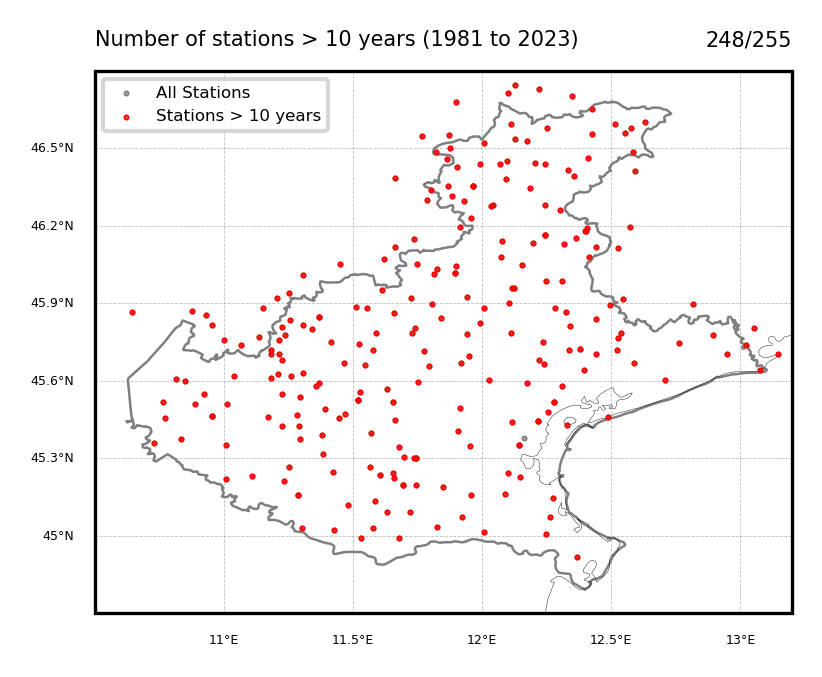

In [31]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

ax1.scatter(INFO_pd['Lon'].values, INFO_pd['Lat'].values, s=0.2, c='grey', zorder=20, label='All Stations')
ax1.scatter(PD_WD['Lon'].values, PD_WD['Lat'].values, s=0.2, c='r', zorder=20, label='Stations > 10 years')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True

gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title(f'Number of stations > 10 years ({year_vector[0]} to {year_vector[-1]})', loc='left', fontsize=5)
ax1.set_title(f'{len(wa_pd)}/{len(INFO_pd)}', loc='right', fontsize=5)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [32]:
# Create a GeoDataFrame for CMORPH grid cells
lon_grid, lat_grid = np.meshgrid(Clon, Clat)
grid_points = pd.DataFrame({'lon': lon_grid.ravel(), 'lat': lat_grid.ravel()})
grid_points = gpd.GeoDataFrame(
    grid_points,
    geometry=gpd.points_from_xy(grid_points['lon'], grid_points['lat']),
    crs="EPSG:4326"
)

In [33]:
# Definir la resolución espacial (en grados)
resolution = 0.25

# Ajustar las coordenadas para que la grilla esté alineada correctamente
# Desplazamos las coordenadas a la mitad de la resolución para corregir el desplazamiento
Clon_adjusted = Clon - (resolution / 2)
Clat_adjusted = Clat - (resolution / 2)

# Agregar una fila en la parte superior y una columna a la derecha
# Esto asegura que la grilla cubra toda el área y agregue el borde superior y derecho
Clon_adjusted = np.append(Clon_adjusted, Clon_adjusted[-1] + resolution)
Clat_adjusted = np.append(Clat_adjusted, Clat_adjusted[-1] + resolution)

# Crear las celdas de la grilla utilizando las coordenadas ajustadas
grid_cells = []
for i in range(len(Clon_adjusted) - 1):
    for j in range(len(Clat_adjusted) - 1):
        # Crear una celda de la grilla como un polígono rectangular (cuadrado)
        grid_cells.append(box(Clon_adjusted[i], Clat_adjusted[j], Clon_adjusted[i + 1], Clat_adjusted[j + 1]))

# Crear un GeoDataFrame con las celdas de la grilla
grid_gdf = gpd.GeoDataFrame(
    geometry=grid_cells,
    crs="EPSG:4326"
)

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


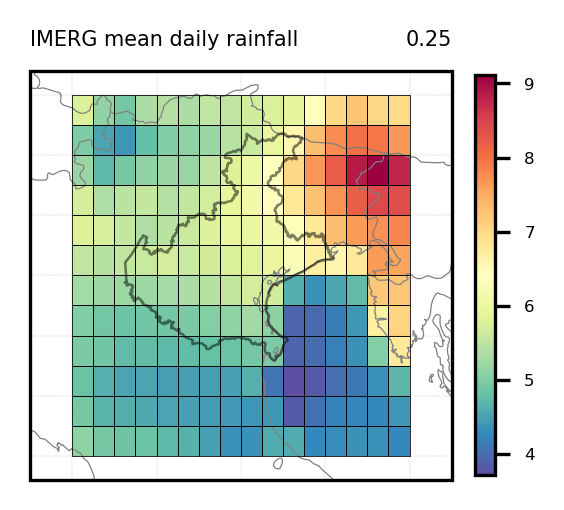

In [34]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

ax1.set_extent([9.5, 14.5, 43.8, 47.2], crs=proj)

grid_gdf.boundary.plot(ax=ax1,linewidth=0.2, edgecolor='black')
a1 = ax1.pcolormesh(Clon2d, Clat2d, IMERG_data['PRE'].mean(axis=0), cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.1,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('IMERG mean daily rainfall', loc='left', fontsize=5)
ax1.set_title(resolution, loc='right', fontsize=5)

cbar = plt.colorbar(a1, fraction=0.043)
cbar.ax.tick_params(labelsize=4)

In [35]:
# Crear un GeoDataFrame con las celdas de la grilla - Wet days
grid_gdf = gpd.GeoDataFrame(
    geometry=grid_cells,
    crs="EPSG:4326"
)

points_WD = pd.DataFrame(PD_WD.iloc[:,4:])
points_WD['lat'] = PD_WD['Lat']
points_WD['lon'] = PD_WD['Lon']

points_WD_gdf = gpd.GeoDataFrame(
    points_WD,
    geometry=gpd.points_from_xy(points_WD['lon'], points_WD['lat']),
    crs="EPSG:4326")

# Intersección espacial: asignar puntos a las celdas de la grilla de CMORPH
joined = gpd.sjoin(points_WD_gdf, grid_gdf, how="inner", predicate="intersects")

# Agrupar por celdas de la grilla y calcular el promedio de los valores de escala
aggregated = joined.groupby('index_right').agg({col: 'mean' for col in year_vector})
aggregated['index_right'] = aggregated.index

grid_gdf[year_vector] = np.nan
grid_gdf.loc[aggregated.index, year_vector] = aggregated[year_vector].values

WD_matrix = np.zeros([len(year_vector), Cnlat, Cnlon])*np.nan

for idx, row in aggregated.iterrows():
    poly_idx = int(row['index_right'])

    # Encontrar los índices de la celda en la grilla de CMORPH
    grid_cell = grid_gdf.geometry.iloc[poly_idx]
    centroid_lon = np.round(grid_cell.centroid.xy[0][0], 3)
    centroid_lat = np.round(grid_cell.centroid.xy[1][0], 3)

    lon_idx = np.where(Clon == centroid_lon)[0][0]
    lat_idx = np.where(Clat == centroid_lat)[0][0]

    WD_matrix[:, lat_idx, lon_idx] = row.values[:-1]

In [36]:
# Crear un GeoDataFrame con las celdas de la grilla - Scale
grid_gdf = gpd.GeoDataFrame(
    geometry=grid_cells,
    crs="EPSG:4326"
)

points_SC = pd.DataFrame(PD_SC.iloc[:,4:])
points_SC['lat'] = PD_SC['Lat']
points_SC['lon'] = PD_SC['Lon']

points_SC_gdf = gpd.GeoDataFrame(
    points_SC,
    geometry=gpd.points_from_xy(points_SC['lon'], points_SC['lat']),
    crs="EPSG:4326")

joined_SC = gpd.sjoin(points_SC_gdf, grid_gdf, how="inner", predicate="intersects")

aggregated_SC = joined_SC.groupby('index_right').agg({col: 'mean' for col in year_vector})
aggregated_SC['index_right'] = aggregated_SC.index

grid_gdf[year_vector] = np.nan
grid_gdf.loc[aggregated_SC.index, year_vector] = aggregated_SC[year_vector].values

SC_matrix = np.zeros([len(year_vector), Cnlat, Cnlon])*np.nan

for idx, row in aggregated_SC.iterrows():
    poly_idx = int(row['index_right'])

    # Encontrar los índices de la celda en la grilla de CMORPH
    grid_cell = grid_gdf.geometry.iloc[poly_idx]
    centroid_lon = np.round(grid_cell.centroid.xy[0][0], 3)
    centroid_lat = np.round(grid_cell.centroid.xy[1][0], 3)

    lon_idx = np.where(Clon == centroid_lon)[0][0]
    lat_idx = np.where(Clat == centroid_lat)[0][0]

    SC_matrix[:, lat_idx, lon_idx] = row.values[:-1]

In [37]:
# Crear un GeoDataFrame con las celdas de la grilla - Shape
grid_gdf = gpd.GeoDataFrame(
    geometry=grid_cells,
    crs="EPSG:4326"
)

points_SH = pd.DataFrame(PD_SH.iloc[:,4:])
points_SH['lat'] = PD_SH['Lat']
points_SH['lon'] = PD_SH['Lon']

points_SH_gdf = gpd.GeoDataFrame(
    points_SH,
    geometry=gpd.points_from_xy(points_SH['lon'], points_SH['lat']),
    crs="EPSG:4326")

joined_SH = gpd.sjoin(points_SH_gdf, grid_gdf, how="inner", predicate="intersects")

aggregated_SH = joined_SH.groupby('index_right').agg({col: 'mean' for col in year_vector})
aggregated_SH['index_right'] = aggregated_SH.index

grid_gdf[year_vector] = np.nan
grid_gdf.loc[aggregated_SH.index, year_vector] = aggregated_SH[year_vector].values

SH_matrix = np.zeros([len(year_vector), Cnlat, Cnlon])*np.nan

for idx, row in aggregated_SH.iterrows():
    poly_idx = int(row['index_right'])

    grid_cell = grid_gdf.geometry.iloc[poly_idx]
    centroid_lon = np.round(grid_cell.centroid.xy[0][0], 3)
    centroid_lat = np.round(grid_cell.centroid.xy[1][0], 3)

    lon_idx = np.where(Clon == centroid_lon)[0][0]
    lat_idx = np.where(Clat == centroid_lat)[0][0]

    SH_matrix[:, lat_idx, lon_idx] = row.values[:-1]

In [38]:
Tr = np.array([10, 20, 50, 100])
Fi = 1-1/Tr

In [39]:
WEIBULL_xr = xr.Dataset(data_vars={
                "Wetdays": (("time","lat","lon"), WD_matrix),
                "Scale": (("time","lat","lon"), SC_matrix),
                "Shape": (("time","lat","lon"), SH_matrix)},
                    coords={'time': pd.to_datetime(year_vector, format='%Y'), 'RT':Tr, 'lat': Clat, 'lon': Clon},
                    attrs=dict(description=f"Weibull parameters for Veneto rain gauges using IMERG 0.25x0.25 grid"))

WEIBULL_xr.Wetdays.attrs["units"] = "Number of days"
WEIBULL_xr.Wetdays.attrs["long_name"] = "wet days"

WEIBULL_xr.Scale.attrs["units"] = "dimensionless"
WEIBULL_xr.Scale.attrs["long_name"] = "Scale"

WEIBULL_xr.Shape.attrs["units"] = "dimensionless"
WEIBULL_xr.Shape.attrs["long_name"] = "Shape"

WEIBULL_xr.RT.attrs["units"] = "dimensionless"
WEIBULL_xr.RT.attrs["long_name"] = "Return time in years"

WEIBULL_xr.lat.attrs["units"] = "degrees_north"
WEIBULL_xr.lat.attrs["long_name"] = "Latitude"

WEIBULL_xr.lon.attrs["units"] = "degrees_east"
WEIBULL_xr.lon.attrs["long_name"] = "Longitude"

In [40]:
WEIBULL_xr

<xarray.Dataset> Size: 199kB
Dimensions:  (time: 43, lat: 12, lon: 16, RT: 4)
Coordinates:
  * time     (time) datetime64[ns] 344B 1981-01-01 1982-01-01 ... 2023-01-01
  * RT       (RT) int64 32B 10 20 50 100
  * lat      (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
  * lon      (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
Data variables:
    Wetdays  (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Scale    (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Shape    (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Weibull parameters for Veneto rain gauges using IMERG 0.25x...

## Test

In [41]:
year_test = 2010

val = np.array(PD_WD[year_test].values)
val = val.astype(float)
val = np.where(np.isnan(val),0,val)

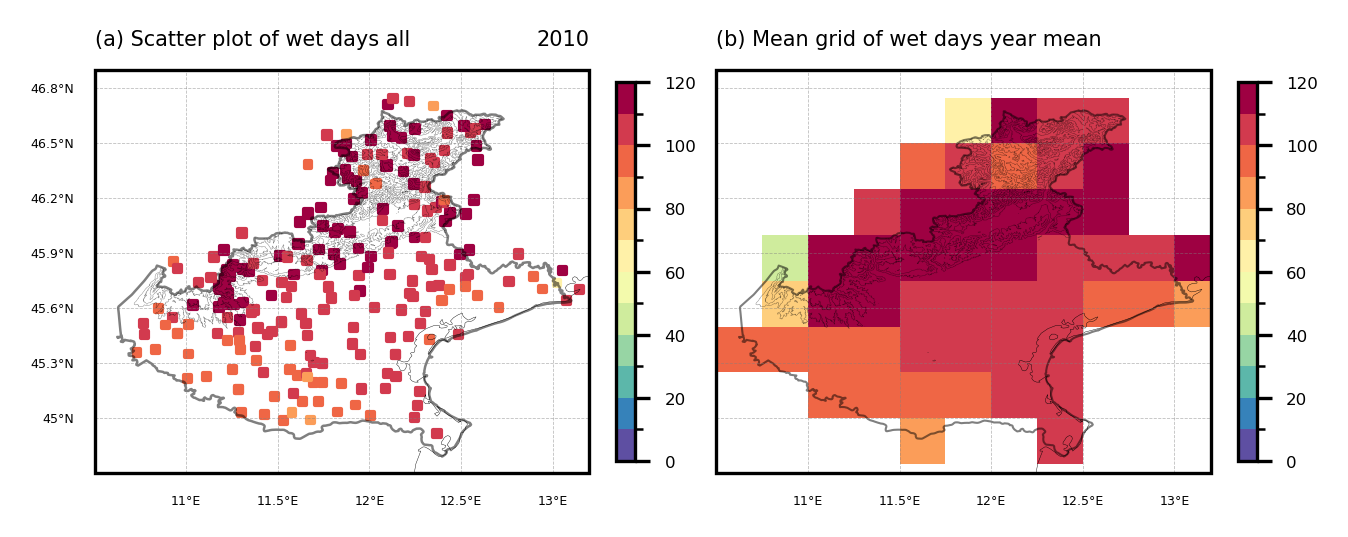

In [42]:
levels = np.arange(0, 130, 10)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a1 = ax1.scatter(PD_WD['Lon'].values, PD_WD['Lat'].values, s=val/np.max(val)*4, c=val, marker='s', cmap=cmap, norm=norm)

# grid_gdf.boundary.plot(ax=ax1,linewidth=0.2, edgecolor='black')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Scatter plot of wet days all', loc='left', fontsize=5)
ax1.set_title(year_test, loc='right', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

WD_val = WEIBULL_xr.sel(time=WEIBULL_xr.time.dt.year.isin([year_test]))['Wetdays'][0,:,:]
a2 = ax1.pcolormesh(Clon2d, Clat2d, np.where(WD_val==0,np.nan,WD_val), cmap=cmap, norm=norm)

# grid_gdf.boundary.plot(ax=ax1,linewidth=0.2, edgecolor='black')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Mean grid of wet days year mean', loc='left', fontsize=5)

# ============================================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.15)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

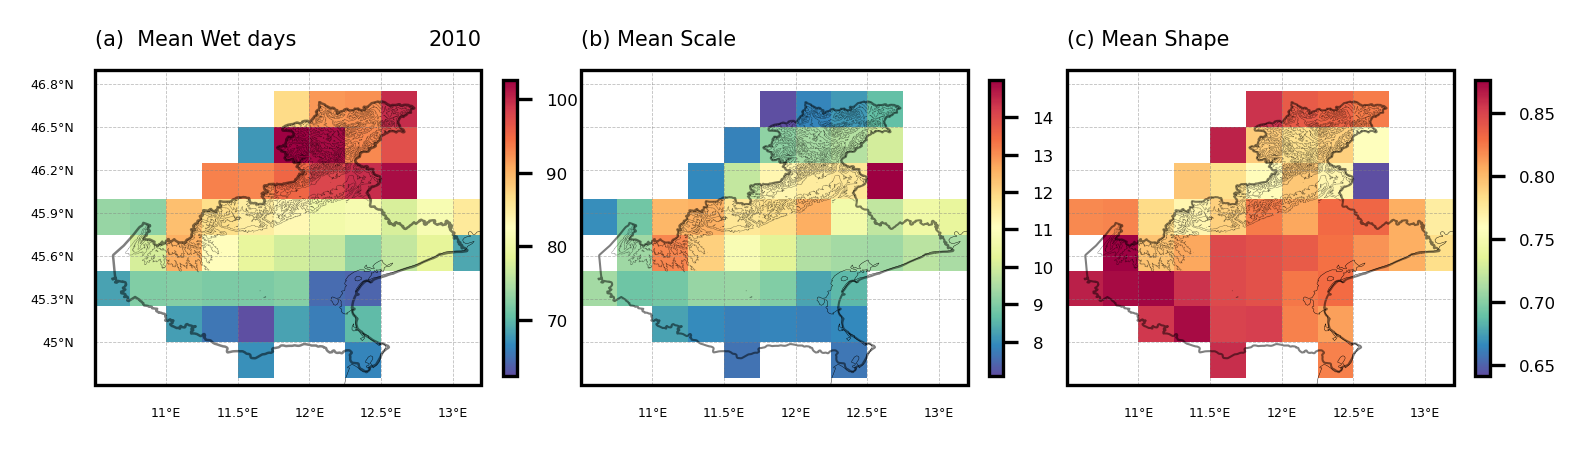

In [43]:
levels = np.arange(0, 130, 10)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

# WD_val = WEIBULL_xr.sel(time=WEIBULL_xr.time.dt.year.isin([year_test]))['Wetdays'][0,:,:]
# a1 = ax1.pcolormesh(Clon2d, Clat2d, np.where(WD_val==0,np.nan,WD_val), cmap=cmap)
a1 = ax1.pcolormesh(Clon2d, Clat2d, WEIBULL_xr['Wetdays'].mean(dim='time'), cmap=cmap)

# grid_gdf.boundary.plot(ax=ax1,linewidth=0.2, edgecolor='black')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a)  Mean Wet days', loc='left', fontsize=5)
ax1.set_title(year_test, loc='right', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

# WD_val = WEIBULL_xr.sel(time=WEIBULL_xr.time.dt.year.isin([year_test]))['Scale'][0,:,:]
# a2 = ax1.pcolormesh(Clon2d, Clat2d, np.where(WD_val==0,np.nan,WD_val), cmap=cmap)
a2 = ax1.pcolormesh(Clon2d, Clat2d, WEIBULL_xr['Scale'].mean(dim='time'), cmap=cmap)

# grid_gdf.boundary.plot(ax=ax1,linewidth=0.2, edgecolor='black')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Mean Scale', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a2 = ax1.pcolormesh(Clon2d, Clat2d, WEIBULL_xr['Shape'].mean(dim='time'), cmap=cmap)

# grid_gdf.boundary.plot(ax=ax1,linewidth=0.2, edgecolor='black')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(c) Mean Shape', loc='left', fontsize=5)

# ============================================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.15)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## Return Time

In [44]:
OBS_Q = np.zeros([len(Tr), len(Clat), len(Clon)])*np.nan
for i in range(len(Clat)):
    for j in range(len(Clon)):
        data_tmp = WEIBULL_xr['Scale'][:,i,j].values
        x0 = 9.0*np.nanmean(data_tmp)
        if np.isnan(data_tmp).sum() == len(data_tmp):
            continue
        else:
            quant = mev_quant(Fi, x0, 
                                    WEIBULL_xr['Wetdays'][:,i,j].values, 
                                    WEIBULL_xr['Scale'][:,i,j].values, 
                                    WEIBULL_xr['Shape'][:,i,j].values,
                                    thresh=1)[0]
            OBS_Q[:,i,j] = quant

pos_10 = np.where(Tr==10)[0][0]
pos_50 = np.where(Tr==50)[0][0]
pos_100 = np.where(Tr==100)[0][0]

/tmp/ipykernel_8215/2982798016.py:5: RuntimeWarning: Mean of empty slice
  x0 = 9.0*np.nanmean(data_tmp)


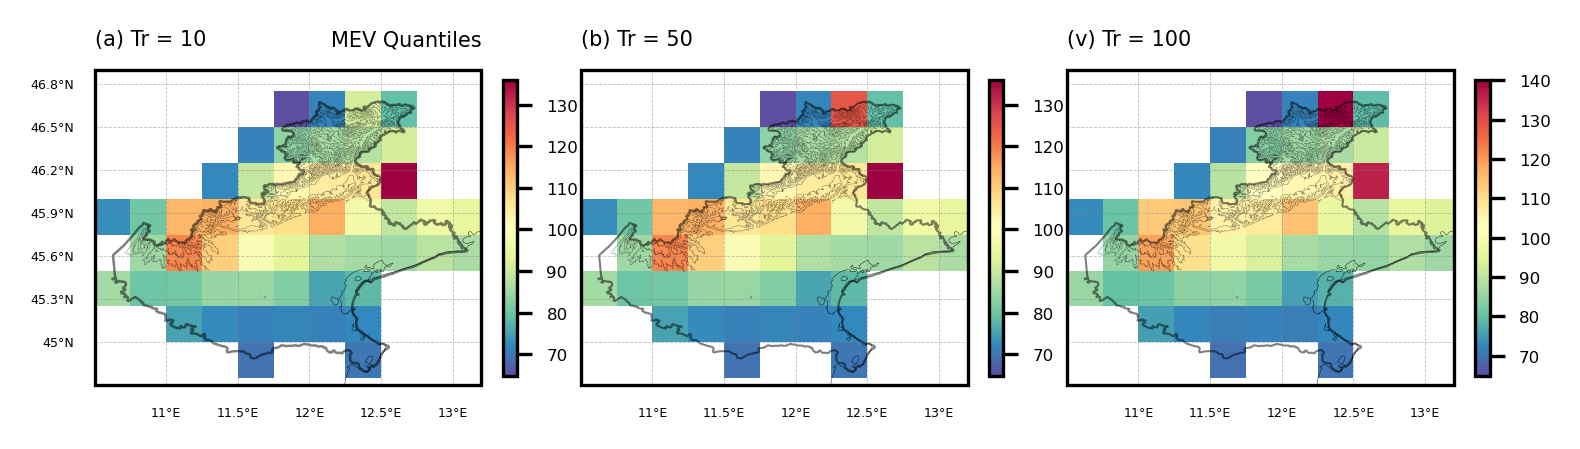

In [45]:
levels = np.arange(0, 130, 10)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a1 = ax1.pcolormesh(Clon2d, Clat2d, OBS_Q[pos_10,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Tr = {Tr[pos_10]}', loc='left', fontsize=5)
ax1.set_title('MEV Quantiles', loc='right', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a2 = ax1.pcolormesh(Clon2d, Clat2d, OBS_Q[pos_50,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Tr = {Tr[pos_50]}', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a2 = ax1.pcolormesh(Clon2d, Clat2d, OBS_Q[pos_100,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(v) Tr = {Tr[pos_100]}', loc='left', fontsize=5)

# ============================================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.15)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [46]:
WEIBULL_xr["Quantile"] = (("RT", "lat", "lon"), OBS_Q)
WEIBULL_xr.Quantile.attrs["units"] = "dimensionless"
WEIBULL_xr.Quantile.attrs["long_name"] = "Quantile" 

In [47]:
WEIBULL_xr

<xarray.Dataset> Size: 205kB
Dimensions:   (time: 43, lat: 12, lon: 16, RT: 4)
Coordinates:
  * time      (time) datetime64[ns] 344B 1981-01-01 1982-01-01 ... 2023-01-01
  * RT        (RT) int64 32B 10 20 50 100
  * lat       (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
  * lon       (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
Data variables:
    Wetdays   (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Scale     (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Shape     (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Quantile  (RT, lat, lon) float64 6kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Weibull parameters for Veneto rain gauges using IMERG 0.25x...

In [48]:
dir_out = os.path.join('/','media','arturo','Arturo','Data','Italy')
WEIBULL_out = os.path.join(dir_out,'Weibull',f'VENETO_WEIBULL_OBS_IMERG_05x05_{year_vector[0]}_{year_vector[-1]}.nc')
print(f'Export PRE data to {WEIBULL_out}')
WEIBULL_xr.to_netcdf(WEIBULL_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_OBS_IMERG_05x05_1981_2023.nc
